# Run a Watershed

This Notebook covers running a calibrated NEWT model for a selected watershed.

In [54]:
import pandas as pd
import pandas.plotting as pdp
import numpy as np
import matplotlib.pyplot as plt
import dataretrieval.nwis as nwis
import pynldas2 as nldas
import s3fs
import zarr
import xarray as xr
import rioxarray as rio
import cartopy.crs as ccrs
import metpy
import os
import warnings
from pynhd import NLDI
from NEWT import Watershed, perf_summary, NextBmi
import NEWT.datatools as datatools

In [14]:
sagehen = "10343500"
eagle = "394220106431500"
ws = sagehen

In [15]:
use_origin = True
if use_origin:
    raw = pd.read_csv(r"X:\Rio.Data\StreamTemperature\NEXT\ReadyData\daymet_aoi\USGS-" + f"{ws}.csv")
    raw["date"] = pd.to_datetime(raw["datetime"]).dt.date
    raw = raw.set_index(["date", "variable"])["mean"].unstack(1)[["tmax", "prcp", "vp", "srad"]]
else:
    raw = pd.read_csv("AllData.csv", dtype={"id": "str"})
    raw = raw[raw["id"] == ws]
    raw["date"] = pd.to_datetime(raw["date"]).dt.date
    raw = raw.set_index("date")[["tmax", "prcp", "vp", "srad"]]
raw

variable,tmax,prcp,vp,srad
date,,,,
2000-01-01,1.196154,5.166539,288.28152,210.08499
2000-01-02,-0.663077,0.000000,208.34999,300.11150
2000-01-03,6.506923,0.000000,339.36383,304.52692
2000-01-04,1.881923,0.000000,347.22806,257.92307
2000-01-05,1.855000,0.000000,272.50308,296.13538
...,...,...,...,...
2022-12-27,3.190384,39.528847,492.26614,131.42460
2022-12-28,1.175385,0.000000,377.98580,210.27731
2022-12-29,2.854615,9.133078,437.02386,156.36731


In [16]:
stdat = nwis.get_dv(sites=[ws], start="2000-01-01", end="2022-12-31", parameterCd="00010")[0].assign(date=lambda x: x.index.date)[["date", "00010_Mean"]].rename(columns={"00010_Mean": "temperature"}).set_index("date").dropna()
stdat

,temperature
date,
2016-10-01,7.1
2016-10-02,5.2
2016-10-03,5.0
2016-10-04,5.1
2016-10-05,4.4
...,...
2022-12-27,1.4
2022-12-28,1.5
2022-12-29,2.3


In [17]:
# Optional: add streamflow
qdat = nwis.get_dv(sites=[ws], start="2000-01-01", end="2022-12-31", parameterCd="00060")[0].assign(date=lambda x: x.index.date)[["date", "00060_Mean"]].rename(columns={"00060_Mean": "Q"}).set_index("date").dropna()
qdat

,Q
date,
2000-01-01,4.10
2000-01-02,4.10
2000-01-03,4.10
2000-01-04,4.20
2000-01-05,4.10
...,...
2022-12-27,13.30
2022-12-28,6.98
2022-12-29,4.30


In [18]:
data = stdat.merge(raw, on="date").merge(qdat, on="date")
data["date"] = pd.to_datetime(data.index).normalize()
data.index = range(len(data))
data

,temperature,tmax,prcp,vp,srad,Q,date
0,7.1,14.275771,0.000000,220.44577,364.96040,1.21,2016-10-01
1,5.2,8.242693,5.740000,237.84767,217.50922,1.27,2016-10-02
2,5.0,4.947692,1.946538,246.82191,209.17538,1.39,2016-10-03
3,5.1,9.919999,0.000000,183.59769,324.39578,1.39,2016-10-04
4,4.4,10.171153,0.000000,168.00691,350.29657,1.34,2016-10-05
...,...,...,...,...,...,...,...
2208,1.4,3.190384,39.528847,492.26614,131.42460,13.30,2022-12-27
2209,1.5,1.175385,0.000000,377.98580,210.27731,6.98,2022-12-28
2210,2.3,2.854615,9.133078,437.02386,156.36731,4.30,2022-12-29
2211,1.7,4.925000,74.243460,633.59540,100.43615,22.80,2022-12-30


In [19]:
cut = round(len(data) * 0.7)
cal = data.iloc[:cut,:].copy()
val = data.iloc[cut:,:].copy()
print(f"Cal: {min(cal['date'].dt.date)} - {max(cal['date'].dt.date)} | Val: {min(val['date'].dt.date)} - {max(val['date'].dt.date)}")

Cal: 2016-10-01 - 2021-03-07 | Val: 2021-03-08 - 2022-12-31


In [20]:
model = Watershed.from_data(cal)

In [21]:
pred = model.run_series(val)

In [22]:
pred

,temperature,tmax,prcp,vp,srad,Q,date,actemp,anom,temp.mod
0,2.3,-0.067308,5.101539,417.22424,174.98845,3.00,2021-03-08,1.376793,-0.013914,1.362880
1,2.0,0.059615,7.916924,361.78842,240.03961,2.88,2021-03-09,1.391377,-0.039813,1.351565
2,1.9,-0.505385,7.974231,297.20575,301.87463,2.82,2021-03-10,1.406976,-0.091061,1.315915
3,1.4,0.076538,4.426923,235.41310,372.44543,2.74,2021-03-11,1.423624,-0.227934,1.195690
4,2.3,3.977693,0.000000,337.50232,480.16653,2.67,2021-03-12,1.396241,-0.427640,0.968601
...,...,...,...,...,...,...,...,...,...,...
659,1.4,3.190384,39.528847,492.26614,131.42460,13.30,2022-12-27,1.372266,0.797763,2.170030
660,1.5,1.175385,0.000000,377.98580,210.27731,6.98,2022-12-28,1.363721,0.401039,1.764760
661,2.3,2.854615,9.133078,437.02386,156.36731,4.30,2022-12-29,1.355744,-0.006904,1.348841
662,1.7,4.925000,74.243460,633.59540,100.43615,22.80,2022-12-30,1.348306,-0.283799,1.064507


In [23]:
perf_summary(pred)

,R2,RMSE,NSE,Pbias,Bias,MaxMiss
0,0.943332,1.285795,0.911358,-11.574786,-0.765261,2.082122


In [74]:
pred["day"] = pred["date"].dt.day_of_year
pred["obs_grad"] = np.gradient(pred["temperature"])
pred["mod_grad"] = np.gradient(pred["temp.mod"])
pred_anom = pred.set_index("date").groupby("day")[["tmax", "prcp", "Q", "srad", "obs_grad", "mod_grad"]].transform(lambda x: x - x.mean()) #.rolling(30, center=True).mean()

For Eagle River, all major unmodeled temperature spikes correspond to sustained low flows (30-day mean), but not to any consistent air temperature pattern at the time, and precipitation and solar radiation show no effect.  Both temperature spikes did correspond to a large and sustained positive air temperature anomaly around the end of the previous calendar year, which could cause the low flows (snow melting off early or falling as rain).  Both do correspond to a similarly-shaped air temperature spike, but disproportionately, and in the 2021 spike there is a substantial lag between the air temperature and water temperature spikes.  At a longer timescale, the persistent relationship is in a hot winter and low-flow summer.  This consistently suggests that the missed spike is indeed seasonal in character.  How about if we add the gradient?

The gradients are noisy, but we do see that the model is consistently underestimating the temperature gradients.  This is sustained during the heat waves, but true across the board.  Possibly there is a nonlinear air temperature response that is being missed as well?

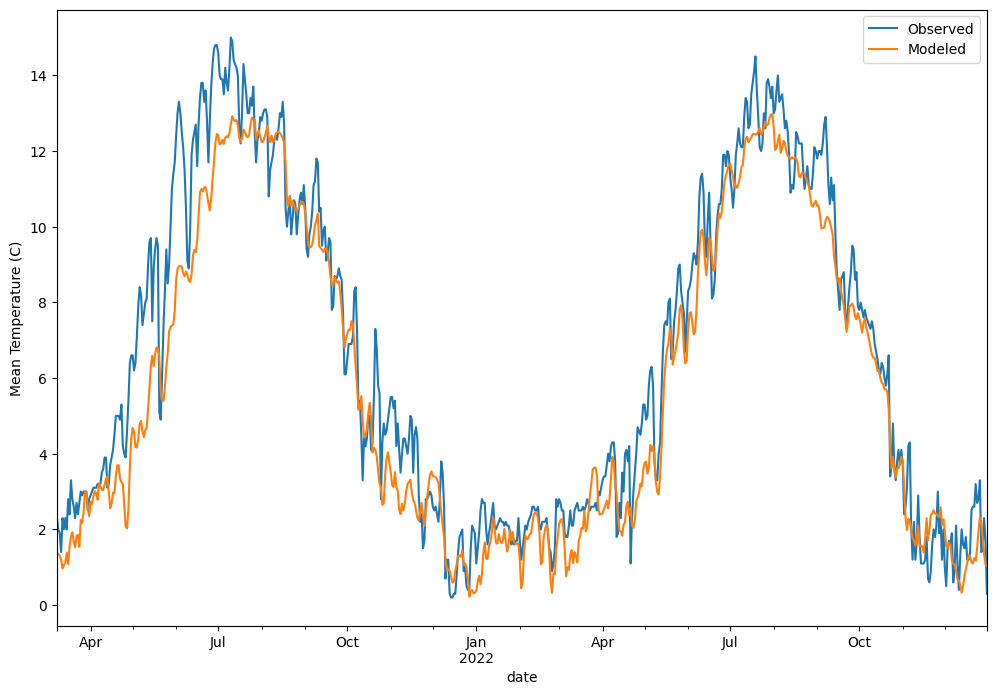

In [24]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
# fig, axes = plt.subplots(3, 1, figsize=(12,9), sharex=True)
# ax = axes[0]
pred.plot(x="date", y="temperature", label="Observed", ax=ax)
pred.plot(x="date", y="temp.mod", label="Modeled", ax=ax)
# ax.set_xlabel("Date")
ax.set_ylabel("Mean Temperature (C)")
# _ = ax.set_title("Eagle River")
# pred_anom.plot(y="Q", ax=axes[1])
# axes[1].set_ylabel("Q anomaly (cfs)")
# pred_anom.plot(y="obs_grad", label="Observed", ax=axes[1])
# pred_anom.plot(y="mod_grad", label="Modeled", ax=axes[1])
# axes[1].set_ylabel("Temperature Gradient (C/day")
# pred_anom.plot(y="tmax", ax=axes[2])
# axes[2].set_ylabel("Air Temperature Anomaly (C)")
# _ = axes[-1].set_xlabel("Date")
fig.savefig("results/SagehenCalibrated.png")

## BMI Version

Let's try this with the BMI.  We'll export the calibrated model above, then use it to run the validation period.

It works!  Awesome.

In [11]:
file = f"model{ws}.yaml"
model.date = val["date"].iloc[0]
model.to_file(file)  # Note: with numpy arrays and stuff, the serialization is bizarre but it works

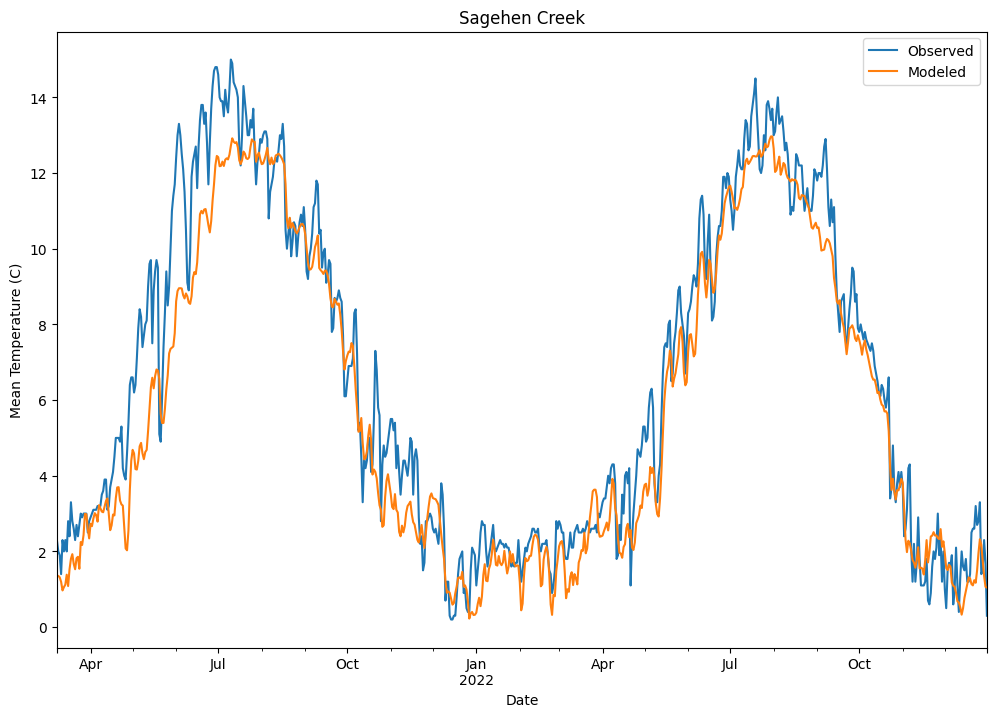

In [12]:
# First, make sure file I/O works
mod2 = Watershed.from_file(file)
pred = mod2.run_series(val)
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
pred.plot(x="date", y="temperature", label="Observed", ax=ax)
pred.plot(x="date", y="temp.mod", label="Modeled", ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Mean Temperature (C)")
_ = ax.set_title("Sagehen Creek")

In [13]:
# Now, do it with BMI.
bmi = NextBmi()
bmi.initialize(file)

In [14]:
bmi._model.date

Timestamp('2021-03-08 00:00:00')

In [15]:
at = bmi.get_input_var_names()
st = bmi.get_output_var_names()[0]
def runner(mod, row):
    mod.set_value(at, np.array([row.tmax]))
    # mod.set_value(vp, np.array([row.vp]))
    mod.update()
    return mod.get_value(st, np.array([1.0]))[0]

In [16]:
bpr = val.copy()
bpr["temp.mod"] = [runner(bmi, row) for row in bpr.itertuples()]

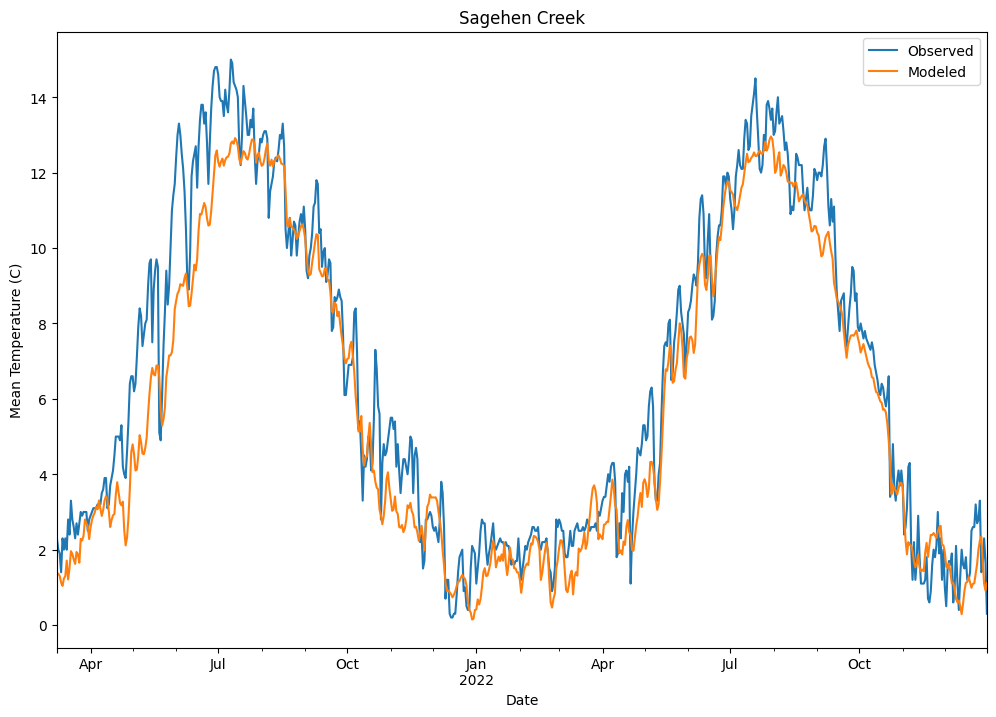

In [17]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
bpr.plot(x="date", y="temperature", label="Observed", ax=ax)
bpr.plot(x="date", y="temp.mod", label="Modeled", ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Mean Temperature (C)")
_ = ax.set_title("Sagehen Creek")

# Near-Real Time

In my use case, daymet data runs through 2022.  After that, switch to using more recent data.  In this test, climatology is *not* adjusted.  We can use NLDAS data to fill in the gaps and get very recent.

In [4]:
nldi = NLDI()
basin = nldi.get_basins(ws)
geo = basin.geometry.iloc[0]

<Axes: >

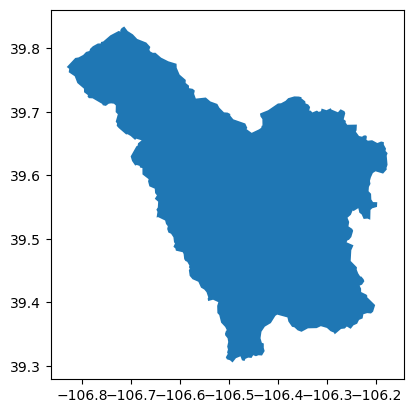

In [5]:
basin.plot()

In [6]:
rt_tmax = datatools.get_nldas(geo, "temp", "tmax", "2023-01-01", "2024-07-30")
rt_tmax

/home/jovyan/newt-proto/src/NEWT/datatools.py:37: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  groupby("time").map(lambda x: x.mean()).to_dataframe()


,tmax
date,
2023-01-01,0.390455
2023-01-02,-1.632727
2023-01-03,-6.146364
2023-01-04,-8.234091
2023-01-05,-1.137273
...,...
2024-07-26,21.575000
2024-07-27,19.975455
2024-07-28,19.270909


In [ ]:
data_now = nwis.get_dv(sites=[ws], start="2023-01-01", end="2024-07-20", parameterCd="00010")[0].assign(date=lambda x: x.index.date)[["date", "00010_Mean"]].rename(columns={"00010_Mean": "temperature"}).set_index("date").dropna().merge(rt_tmax, on="date")
data_now["date"] = pd.to_datetime(data_now.index)
data_now = pd.concat([val[["temperature", "tmax", "date"]], data_now])
data_now.index = range(len(data_now))
data_now

In [84]:
prd_now = model.run_series(data_now)

In [85]:
perf_summary(prd_now)

,R2,RMSE,NSE,Pbias,Bias,MaxMiss
0,0.937969,1.468306,0.936582,-1.077893,-0.0751,3.522854


<Axes: xlabel='date'>

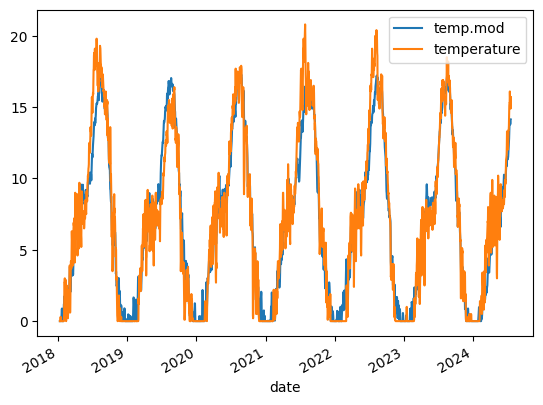

In [86]:
ax = prd_now.plot(x="date", y="temp.mod")
prd_now.plot(x="date", y="temperature", ax=ax)

# Forecast

See: https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/zarr_HowToDownload.html

Wherein we download zarr-format HRRR data and run an actual forecast.  Starting at GMT 0600 means the first 24 hours capture most of the day for all of the CONUS and we can use that for a decent estimate at daily tmax.

## Full Forecast Run

Trail a model on the full available dataset (through 2022), then run a (re)forecast at 72-hour lead time for 2023-24.  How does that work with 48-hour forecasts?  Day-0 temperature is actually ignored, so we use the day-2 (24-48 hour) forecast for the data source, then set air temperature to zero for the last day (i.e., three days from "now").  Compute performance for the data-coverage period and make a note of forecasted temperatures.

In [88]:
rerun = False
file = f"results/weather_forecast_{ws}.csv"
today = np.datetime64("today")
strify = lambda date: "".join(str(date).split("-"))[:8]
geo = datatools.get_shape_usgs(ws)
mod = Watershed.from_data(data)
obs = nwis.get_dv(sites=[ws], start="2023-01-01", end=str(today), parameterCd="00010")[0].assign(date=lambda x: x.index.date)[["date", "00010_Mean"]].rename(columns={"00010_Mean": "temperature"}).set_index("date").dropna()
obs.index = pd.to_datetime(obs.index)

In [62]:
# lambda date: datatools.forecast_areal_summary(datatools.forecast_watershed_clip(datatools.get_daily_forecasts(strify(date), var="TMP"), geo), "tmax")["tmax"].iloc[1]
def get_data(date):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            st = strify(date)
            print(st, end=" ")
            return datatools.forecast_areal_summary(
                datatools.forecast_watershed_clip(
                    datatools.get_daily_forecasts(st, var="TMP"), geo), "tmax")["tmax"].iloc[1]
        except:
            return np.NaN

def run_wfr():
    run_dates = np.arange(np.datetime64("2023-01-01"), np.datetime64("today") + 1)
    fcst_dates = run_dates + 1
    return pd.DataFrame({"date": fcst_dates, "tmax": pd.Series(run_dates).apply(get_data)})

In [81]:
if rerun or not os.path.exists(file):
    wfr = run_wfr()
    wfr.to_csv(file, index=False)
else:
    wfr = pd.read_csv(file)
    wfr["date"] = pd.to_datetime(wfr["date"])

In [82]:
wfr = pd.concat([wfr, pd.DataFrame({
    "date": wfr["date"].iloc[-1] + np.timedelta64(1, "D"),
    "tmax": wfr["tmax"].iloc[-1]
}, index = [len(wfr)])])

In [85]:
pred = mod.run_series(wfr)
pred

,date,tmax,actemp,anom,temp.mod
0,2023-01-02,-1.416667,1.505830,-0.016889,1.488941
1,2023-01-03,0.916667,1.502431,-0.045780,1.456652
2,2023-01-04,2.833333,1.499441,-0.061656,1.437786
3,2023-01-05,1.666667,1.496831,-0.097096,1.399735
4,2023-01-06,0.250000,1.494570,-0.256378,1.238192
...,...,...,...,...,...
583,2024-08-07,35.166668,12.256327,1.538549,13.794876
584,2024-08-08,35.416668,12.198995,1.606079,13.805075
585,2024-08-09,34.666668,12.138362,1.643187,13.781549
586,2024-08-10,34.000000,12.074496,1.657137,13.731633


As of August 9, 2024, the Sagehen (re)forecasts for mean temperature are:

- August 9: 13.8 C (1.6 C above mean)
- August 10: 13.7 C (1.7 C above mean)
- August 11: 13.5 C (1.5 C above mean)

In [93]:
compare = pred.merge(obs, on="date", how="left")
perf_summary(compare)

,R2,RMSE,NSE,Pbias,Bias,MaxMiss
0,0.809,2.034757,0.753994,2.780608,0.148347,0.287409


In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
compare.plot(x="date", y="temp.mod", label="(Re)forecast (48-hour lead)", ax=ax)
compare.plot(x="date", y="temperature", label="Observed", ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Daily Mean Temperature (C)")
plt.savefig("results/SagehenCalibratedForecast.png")

## Pull Forecast Data

C:\Users\dphilippus\OneDrive - Colorado School of Mines\PhD\NEXT\newt\src\NEWT\datatools.py:66: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds["time"] = (ds["time"] - np.timedelta64(6, 'h')).astype("datetime64[D]")  # approximate, but gets it to the right day-ish


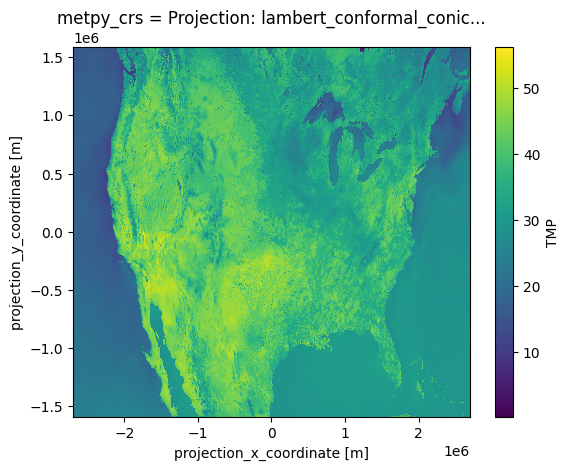

In [7]:
geom = datatools.get_shape_usgs(ws)
tmax = datatools.get_daily_forecasts("20240801", var="TMP")
tmax[0,:,:].plot()

This part seems to be mysteriously crashing when I try to extract it, but the same code worked before.  I'm going to see if it's a server issue and try running it on desktop.

Confirmed: this causes a mysterious kernel crash on 2i2C, but runs fine on desktop.

## Clip to Watershed

In [8]:
clip = datatools.forecast_watershed_clip(tmax, geom)

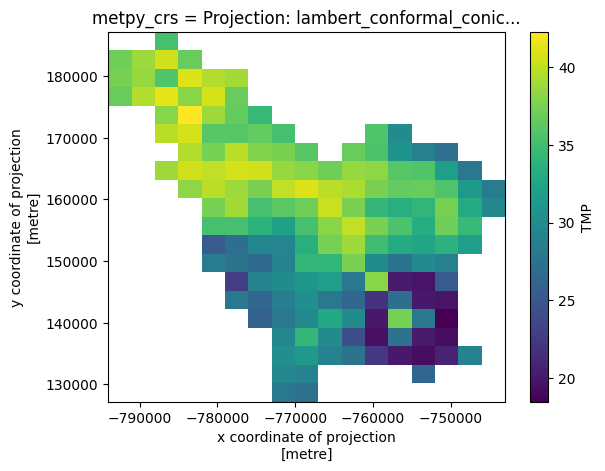

In [10]:
clip[0,:,:].plot()

## Compute Areal Means

In [39]:
temps = datatools.forecast_areal_summary(clip, "tmax")
temps["tmax"].iloc[1]

C:\Users\dphilippus\OneDrive - Colorado School of Mines\PhD\NEXT\newt\src\NEWT\datatools.py:95: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  summary = clipped_fcst.groupby("time").map(operator).to_pandas().rename(new_name)


33.125